# Analyzing data from LAMMPS

The following script shows how to use `freud` to compute the radial distribution function $g(r)$ on data generated by the molecular dynamics simulation engine LAMMPS. The input script runs a Lennard-Jones system, which is then parsed with `numpy.genfromtxt`.

The input script is below. Note that we must dump images with `ix iy iz`, so that the mean squared displacement can be calculated correctly.

In [1]:
!cat lj.in

#  From http://utkstair.org/clausius/docs/mse614/text/examples.html
#  define units
units       lj

#  specify periodic boundary conditions
boundary p p p

#  define atom_style
#  full covers everything
atom_style  full 

#  define simulation volume 
#  If I want N = 512 atoms 
#  and I want a density of rho = 0.5 atoms/lj-sigma^3
#  Then I can determine the size of a cube by 
#  size = (N/rho)^(1/3)
variable side      equal 10
region      boxid block 0.0 ${side} 0.0 ${side} 0.0 ${side}
create_box  1 boxid

#  specify initial positions of atoms
#  sc = simple cubic
#  0.5 = density in lj units
lattice     sc 0.50

#  place atoms of type 1 in boxid
create_atoms    1 box

#   define mass of atom type 1
mass        1 1.0

#  specify initial velocity of atoms
#  group = all
#  reduced temperature is T = 1.0 = lj-eps/kb 
#  seed for random number generator
#  distribution is gaussian (e.g. Maxwell-Boltzmann)
velocity    all create 1.0 87287 dist gaussian

#  specify interaction potential
# 

Next, we run LAMMPS to generate the output file. LAMMPS can be installed with `conda install -c conda-forge lammps`.

In [2]:
!lmp_serial -in lj.in

LAMMPS (5 Jun 2019)
Created orthogonal box = (0 0 0) to (10 10 10)
  1 by 1 by 1 MPI processor grid
Lattice spacing in x,y,z = 1.25992 1.25992 1.25992
Created 512 atoms
  create_atoms CPU = 0.00122023 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.8
  ghost atom cutoff = 2.8
  binsize = 1.4, bins = 8 8 8
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 6.109 | 6.109 | 6.109 Mbytes
Step PotEng KinEng TotEng Temp Press Density 
       0   -1804.3284        766.5   -1037.8284            1   -2.1872025        0.512 
     100   -1834.8127    774.55302   -1060.2596    1.0105062  -0.32671112   

    5200   -1810.7731     731.9772   -1078.7959   0.95496047  -0.16033508        0.512 
    5300   -1837.5311    749.48424   -1088.0469   0.97780071  -0.20281441        0.512 
    5400   -1873.1094    764.60064   -1108.5088   0.99752204  -0.41358648        0.512 
    5500   -1888.9361    748.61774   -1140.3184   0.97667025  -0.36938658        0.512 
    5600   -1869.9513    762.05258   -1107.8988   0.99419776   -0.4223791        0.512 
    5700    -1858.339    746.55871   -1111.7803   0.97398396  -0.42269281        0.512 
    5800   -1863.2613    749.34951   -1113.9118   0.97762493  -0.38710722        0.512 
    5900   -1873.7293    773.93107   -1099.7982    1.0096948  -0.26021895        0.512 
    6000    -1873.456    787.00426   -1086.4518    1.0267505  -0.22677264        0.512 
    6100   -1856.3965    789.71834   -1066.6782    1.0302914  -0.23662444        0.512 
    6200   -1868.1487    781.09973   -1087.0489    1.0190473  -0.13471937        0.512 
    6300   -1873.9941    740.706

In [3]:
%matplotlib inline

import warnings

import freud
import numpy as np
from matplotlib import pyplot as plt

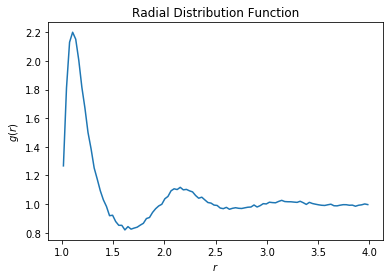

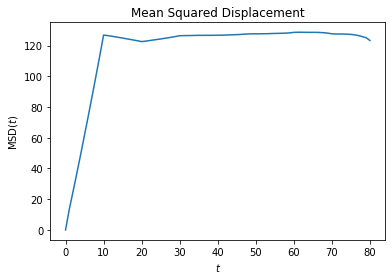

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # We read the number of particles, the system box, and the
    # particle positions into 3 separate arrays.
    N = int(np.genfromtxt("output_custom.xyz", skip_header=3, max_rows=1))
    box_data = np.genfromtxt("output_custom.xyz", skip_header=5, max_rows=3)
    data = np.genfromtxt("output_custom.xyz", skip_header=9, invalid_raise=False)

# Remove the unwanted text rows
data = data[~np.isnan(data).all(axis=1)].reshape(-1, N, 6)

box = freud.box.Box.from_box(box_data[:, 1] - box_data[:, 0])

# We shift the system by half the box lengths to match the
# freud coordinate system, which is centered at the origin.
# Since all methods support periodicity, this shift is simply
# for consistency but does not affect any analyses.
data[..., :3] -= box.L / 2
rdf = freud.density.RDF(bins=100, r_max=4, r_min=1)
for frame in data:
    rdf.compute(system=(box, frame[:, :3]), reset=False)

msd = freud.msd.MSD(box)
msd.compute(positions=data[:, :, :3], images=data[:, :, 3:])

# Plot the RDF
plt.plot(rdf.bin_centers, rdf.rdf)
plt.title("Radial Distribution Function")
plt.xlabel("$r$")
plt.ylabel("$g(r)$")
plt.show()

# Plot the MSD
plt.plot(msd.msd)
plt.title("Mean Squared Displacement")
plt.xlabel("$t$")
plt.ylabel("MSD$(t)$")
plt.show()